In [35]:
from tqdm.notebook import tqdm
import pdb 

In [49]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table
# import astropy.units as u

# Dlnpyutils
# from dlnpyutils import utils
from dlnpyutils.utils import bspline,mad

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

class Astrologium():
    '''
    A class to calculate a star's extinction, age and mass using PARSEC isochrones with 
    Gaia (E)DR3 and 2MASS photometry.
    '''
    def __init__(self,teff,logg,abund,obsphot,distance,isochrones,ext_law='CCM89',rv=3.1):
        
        '''
        Inputs:
        ------
            teff:       2x1 array-like
                        Teff and error of star np.array([teff,teff_err])
                        
            logg:       2x1 array-like
                        Log(g) and error of star np.array([logg,logg_err])
                    
            abund:      2x1 array-like
                        first column is [M/H] and [Alpha/M] and the second column is the errors
                    
            obs_phot:   6x2 array-like
                        first column is BP, G, RP, J, H, and K and the second column is the errors
                        
            distance:   float
                        distance to star in pc
                    
            isochrones: astropy Table 
                        PARSEC isochrone table
                        
            ext_law:    string, optional
                        extinction law to use. Default is CCM89.
                        
                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022
                        
            rv:         float, optional
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1 
                        (required to be 3.1 if ext_law = 'F99')

        '''
        
        # Teff and log(g)
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.logg  = logg[0] # log(g)
        self.logg_err = logg[1] # log(g) error
        
        # Salaris [Fe/H] Asplund 2021 et al.
        self.salfeh = abund[0,0]+np.log10(0.659*(10**(abund[1,0]))+0.341) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.341/(0.659*(10**(abund[1,0]))+0.341))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # Absolute Magnitudes Not Derreddened
        self.absphot = self.phot-self.distmod
        
        # PARSEC isochrones
        self.labels = ['G_BPEDR3mag','GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        self.uniq_masses = np.unique(self.iso['Mass'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
        
        mass_idx = []
        for i in range(len(self.uniq_masses)):
            masses, = np.where(self.iso['Mass']==self.uniq_masses[i])
            mass_idx.append(np.array([min(masses),max(masses)]))
        
        self.mass_idx = np.asarray(mass_idx)
            
        # Effective Wavelengths of different passbands in units of microns
        self.rv = rv
        self.leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]) #BP, G, RP, J, H, K
        self.extlaw_coeff = self.extcoeff(law=ext_law,rv=rv)
        
        # Solar values
        self.lgteff_sun = np.log10(5773.) # +/- 16 K Asplund et al. 2021
        self.logg_sun = 4.4374 # +/- 0.0005 Gray D.F., 1992 
        
        # Calculated Results
        self.exts = self.extinctions()
        self.bcs = self.bolometric_corrections()
        self.mass = self.get_mass()
        self.age = 0
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value

        Inputs:
        ------
            data:  array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value

        Inputs:
        ------
            data:   array-like
                    data to search through

            value:  float or int
                    value of interest

        Output:
        ------
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    #############################################
    ### Extinction and Bolometric Corrections ###
    #############################################
        
    def extcoeff(self,rv=3.1,law='CCM89'):

        '''
        Calculate the relative extincion law coefficients for a given wavelength relative to the 
        BP, G, RP, J, H, K or user defined band

        Input:
        -----
            law:        str
                        extinction law to use

                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022

            rv:         float
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1

        Output:
        ------
            ext_coeff:  float
                        calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                        relative to the Gaia G band

        '''

        leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}

        # select the extinction model
        if law == 'CCM89':
            ext_model = CCM89(Rv=rv)

        elif law == 'O94':
            ext_model = O94(Rv=rv)

        elif law == 'F99':
            ext_model = F99(Rv=rv)

        elif law == 'F04':
            ext_model = F04(Rv=rv)

        elif law == 'VCG04':
            ext_model = VCG04(Rv=rv)

        elif law == 'GCC09':
            ext_model = GCC09(Rv=rv)

        elif law == 'M14':
            ext_model = M14(Rv=rv)

        elif law == 'F19':
            ext_model = F19(Rv=rv)

        elif law == 'D22':
            ext_model = D22(Rv=rv)   

        # Calculate the relative extinction coefficient
        ext_coeff_array = ext_model(np.reciprocal(self.leff*u.micron))

        return ext_coeff_array
    
    def extinctions(self):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and K bands
        
        Output:
        ------
            ext: 6x2 array
                 first column is the extinction values and the second is the errors
            
        '''
        
        # isochrone magnitude labels
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        # pick isochrone points with temperatures within 200 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        # check to make sure teff of star is in range of the isochrone
        if np.size(np.squeeze(teffcut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
    
        # get colors and errors
        obs_colors = np.delete(self.phot[:]-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err[:]**2+self.phot_err[1]**2),1)
        
        # create "reddening" vector (slightly modified from the normal definition)
        red_vec = np.delete(1-self.extlaw_coeff/self.extlaw_coeff[1],1)
        red_vec[0] = -1*red_vec[0]
        
        ext_vec = self.extlaw_coeff/self.extlaw_coeff[1]
        
        # calculate the intrinsic colors using a b-spline
        bspline_vec = 999999.0*np.ones(5)
        bspline_vec_deriv = 999999.0*np.ones(5)
        
        for i in range(5):
            try:
                # Interpolate the color-Teff relation using a b-spline
                color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
                logTe = iso_['logTe']

                bspl = bspline(logTe,color)
                bspline_vec[i] = bspl(np.log10(self.teff[0]))
                bspline_vec_deriv[i] = bspl.derivative()(np.log10(self.teff[0]))
                
            except:
                bspline_vec[i] = 999999.0
                bspline_vec_deriv[i] = 999999.0
                
        # calculate the extinctions and errors
        color_diff = obs_colors-bspline_vec
        
        bspl_errs = np.abs((bspline_vec_deriv*self.teff_err)/(self.teff*np.log(10)))
        color_diff_err = np.sqrt(obs_colors_err**2+bspl_errs**2)

        # find bad values this should take care of bad values from the spline
        neg_cut = np.where(color_diff>0)
        
        # if all bad return bad values
        if np.size(np.squeeze(neg_cut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
        
        # calculate the extinction value and error
        ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        ag_err = np.dot(red_vec[neg_cut],color_diff_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        
        exts = 999999.0*np.ones((6,2))
        exts[:,0] = ext_vec*ag
        exts[:,1] = ext_vec*ag_err
        
        self.exts = exts
#         pdb.set_trace()
        return exts
    
    def bolometric_corrections(self):
        '''
        Calculate the bolometric corrections for each band
        
        Return:
        ------
            bcs: 6x2 array
                 array of bolometric corrections and errors
        '''
        
        # pick isochrone points with temperatures within 200 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        # check to make sure teff of star is in range of the isochrone
        if np.size(np.squeeze(teffcut))==0:
            bcs = 999999.0*np.ones((6,2))
            self.bcs = bcs
            return bcs
        
        bcs = 999999.0*np.ones((6,2))
        for i in range(6):
            try:
                logTe = iso_['logTe']

                bspl = bspline(logTe,iso_['mbolmag']-iso_[self.labels[i]])
                bcs[i,0] = bspl(np.log10(self.teff))
                bcs[i,1] = np.abs(bspl.derivative()(np.log10(self.teff))*self.teff_err)
                
            except:
                bcs[i,0] = 999999.0
                bcs[i,1] = 999999.0
        
        self.bcs = bcs
        return bcs
    
    ####################
    ### Mass and Age ###
    ####################
    
    def get_mass(self):
        '''
        Calculate the mass of a star
        
        Return:
        ------
            mass: 
        '''
        
        lgmasses = 999999.0*np.ones(6)
        lgmasses_err = 999999.0*np.ones(6)
        
        for i in range(6):
            # mass calculation
            mag_part = 0.4*(4.74-self.bcs[i,0]-self.phot[i]+self.distmod+self.exts[i,0])
            spec_part = -4*(np.log10(self.teff)-self.lgteff_sun)-(self.logg-self.logg_sun)
            
            lgmasses[i] = mag_part+spec_part
            
            # mass error calculation
            mag_part_err_sq = (0.4**2)*(self.bcs[i,1]**2+self.phot_err[i]**2+self.exts[i,1]**2)+self.distmod**2
            spec_part_err_sq = (4*self.teff_err/(np.log(10)*self.teff))**2+self.logg_err**2
            
            lgmasses_err[i] = np.sqrt(mag_part_err_sq+spec_part_err_sq)
        
        # weighted sum to get mass and error
        wgts = np.reciprocal(lgmasses_err)
        sum_wgts = sum(wgts)
        
        lgmass = np.dot(wgts,lgmasses)/sum_wgts
        lgmass_err = np.sqrt(1/sum_wgts)
        
        mass = 10**lgmass
        mass_err = mass*np.log(10)*lgmass_err
        
        self.mass = np.array([mass,mass_err])
        
        return np.array([mass,mass_err])
    
#     def mass_2_age(self,mass=None):
#         '''
#         Calculate the age of an RGB star from its mass
        
#         Input:
#         -----
#             mass: float
#                   mass of a star in solar masses
        
#         Output:
#         ------
#             age:  float
#                   age of a star in Gyr
#         '''
        
#         if mass!=None:
            
        
#         else:
#             # check for bad value 
#             if (mass == 999999.0) | (mass < 0.0):
#                 age = 999999.0
#                 return age

#             # do spline to interpolate age as a function of mass
#             age_mass_spline = bspline(self.iso['Mass'],self.iso['logAge'],extrapolate=True)
#             age = 10**age_mass_spline(mass)
        
#         return age
    
#     def age_2_mass(self,age):
#         '''
#         Calculate the mass of a star from its age
        
#         Input:
#         -----
#             age:      2x1 array
#                       age of a star in Gyr and associated error

#         Output:
#         ------
#             mass:     float 
#                       mass of star in solar masses
            
#             mass_err: float
#                       error in the calculated mass of the star
#         '''

#         if self.age == 999999.0:
#             return 999999.0
# #             return np.array([999999.0,999999.0])
        
#         teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
#                            (self.iso['logTe']>np.log10(self.teff-200.)))
#         iso_ = self.iso[teffcut]
        
#         if np.size(iso_) < 2:
#             return 999999.0
# #             return np.array([999999.0,999999.0])
#         try:
#             ### calculate the mass and error using interpolation
#             bspl = bspline(iso_['logAge'],iso_['Mass'])
#             mass = bspl(np.log10(age*10**9))
            
#         except:
#             mass = 999999.0

#         if np.isfinite(mass)==False:
#             return 999999.0
        
#         return mass
 

In [3]:
def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757])

import astropy.units as u
def convert_sfdebv(wave,ebv,rv=3.1):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010
    
    Inputs:
    ------
        wave: wavelength of band to calculate extinction in mircons
        ebv: Schlegel E(B-V) value
        
    Output:
    ------
        new_extinction: extinction in the band with the effective wavelength of wave
    '''
    
    micron_extinction = (0.78/1.32)*ebv
    fitz = F99(Rv=rv)
    return fitz(1/(wave*u.micron))/fitz(1*u.micron)*micron_extinction

import astropy.units as u
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

def extcoeff(wavelength,rv=3.1,law='CCM89',ref='G'):

    '''
    Calculate the relative extincion law coefficients for a given wavelength relative to the 
    BP, G, RP, J, H, K or user defined band

    Input:
    -----
        wavelength: float
                    Effective wavelength of band of interest in microns
        
        law:        str
                    extinction law to use
                         
                    Available Extinction Laws: 
                    -------------------------
                        
                    CCM89 - Cardelli, Clayton, & Mathis 1989
                    O94 - O'Donnell 1994
                    F99 - Fitzpatrick 1999
                    F04 - Fitzpatrick 2004
                    VCG04 - Valencic, Clayton, & Gordon 2004
                    GCC09 - Grodon, Cartledge, & Clayton 2009
                    M14 - Maiz Apellaniz et al 2014
                    F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                    D22 - Decleir et al. 2022

        rv:         float
                    Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
        ref:        str or float
                    reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
                    or user defined float that is the wavelength in microns of the band

    Output:
    ------
        ext_coeff:  float
                    calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                    relative to the Gaia G band

    '''

    leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
    
    # select the extinction model
    if law == 'CCM89':
        ext_model = CCM89(Rv=rv)

    elif law == 'O94':
        ext_model = O94(Rv=rv)

    elif law == 'F99':
        ext_model = F99(Rv=rv)

    elif law == 'F04':
        ext_model = F04(Rv=rv)

    elif law == 'VCG04':
        ext_model = VCG04(Rv=rv)

    elif law == 'GCC09':
        ext_model = GCC09(Rv=rv)

    elif law == 'M14':
        ext_model = M14(Rv=rv)

    elif law == 'F19':
        ext_model = F19(Rv=rv)

    elif law == 'D22':
        ext_model = D22(Rv=rv)   

    # Calculate the relative extinction coefficient
    if type(ref) == str:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(leff[ref]*u.micron)
    
    elif type(ref) == float:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(ref*u.micron)
    
    return ext_coeff

### Geometry

import MagellanicStream as MagellanicStream

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 with parameters from Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y) using equation 6 form Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

# PARSEC

In [4]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive = massive[np.argsort(massive['Mass'])]
massive = massive['MH','Mass','logAge','logTe','logg','G_BPEDR3mag','GEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag','mbolmag']

# I noticed that there's some weird points marked as RGB, so I cut those out with
cut = np.poly1d(np.polyfit([4600,5400],[0.5,2],1))
massive = massive[np.where(massive['logg']>cut(10**massive['logTe']))]

In [5]:
# plt.figure(figsize=[10,10])
# plt.scatter(massive['Mass'],massive['logAge'],c=massive['MH'],cmap='nipy_spectral')
# plt.colorbar()
# plt.title(r'Color as [M/H]')
# plt.xlabel(r'Mass')
# plt.ylabel(r'logAge')
# plt.show()

In [6]:
singfeh = massive[np.where(massive['MH']==closest(massive['MH'],-0.5))]

# mass_age_spl = bspline(singfeh['Mass'],singfeh['logAge'])
# xs = np.linspace(min(singfeh['Mass']),max(singfeh['Mass']))

# plt.figure(figsize=[10,10])
# plt.scatter(singfeh['Mass'],singfeh['logAge'])#,c=singfeh['MH'],cmap='nipy_spectral')
# plt.plot(xs,mass_age_spl(xs),c='r')
# plt.title(r'Color as [M/H]')
# plt.xlabel(r'Mass')
# plt.ylabel(r'logAge')
# plt.show()

In [7]:
# star = np.where(salfeh==closest(salfeh,-0.5))

# plt.figure(figsize=[24,10])
# plt.subplot(121)
# plt.scatter(10**singfeh['logTe'],singfeh['GEDR3mag'],c=singfeh['Mass'],cmap='nipy_spectral')
# plt.colorbar()
# plt.axvline(kdr17['TEFF'][star],lw=3.0,ls='--',c='r')
# plt.title(r'Color as Mass')
# plt.xlabel(r'Teff')
# plt.ylabel(r'G')

# plt.subplot(122)
# plt.scatter(10**singfeh['logTe'],singfeh['GEDR3mag'],c=10**singfeh['logAge']/10**9,cmap='nipy_spectral')
# plt.colorbar()
# plt.axvline(kdr17['TEFF'][star],lw=3.0,ls='--',c='r')
# plt.title(r'Color as age')
# plt.xlabel(r'Teff')
# plt.ylabel(r'G')
# plt.show()

In [8]:
# uniq_masses = np.unique(singfeh['Mass'])
        
# mass_idx = []
# for i in range(len(uniq_masses)):
#     masses, = np.where(singfeh['Mass']==uniq_masses[i])
#     mass_idx.append(np.array([min(masses),max(masses)]))

# mass_idx = np.asarray(mass_idx)

In [9]:
# mass_idx

# APOKASC 

<ipython-input-10-083f89cc5d4b>:3: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


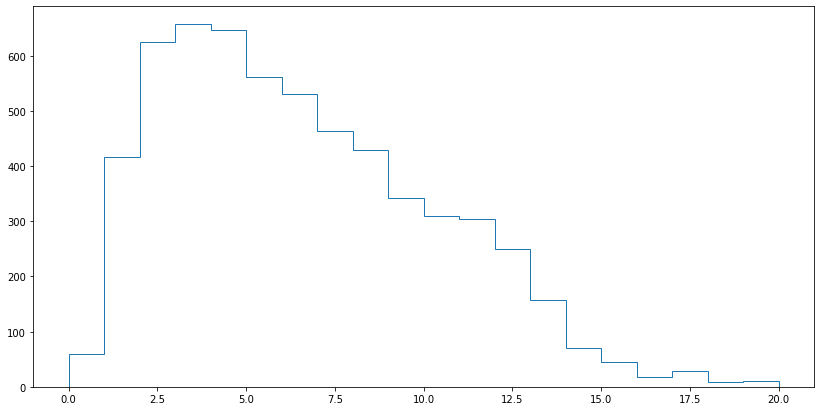

In [10]:
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz')
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

k674 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.4.fits.gz')

# xmatch APOKASC with DR17
_, k674idx, dr17idx = np.intersect1d(k674['2MASS_ID'],dr17['APOGEE_ID'],return_indices=True)

k674 = k674[k674idx]
kdr17 = dr17[dr17idx]
apoafe = apoafe[dr17idx]
apoafe_err = apoafe_err[dr17idx]
salfeh = salfeh[dr17idx]
salfeh_err = salfeh_err[dr17idx]

# Select RGB stars
ageevs = np.where((k674['A3P_AGEMOD_JT']>-10.)&(k674['APOKASC3_CONS_EVSTATES']==1.0)&
                  (np.isfinite(kdr17['FE_H'])==True))

k674 = k674[ageevs]
kdr17 = kdr17[ageevs]
apoafe = apoafe[ageevs]
apoafe_err = apoafe_err[ageevs]
salfeh = salfeh[ageevs]
salfeh_err = salfeh_err[ageevs]

plt.figure(figsize=[14,7])
plt.hist(k674['A3P_AGEMOD_JT'],histtype='step',range=(0,20),bins=20)
plt.show()

# Gaia Mag Errors

In [11]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

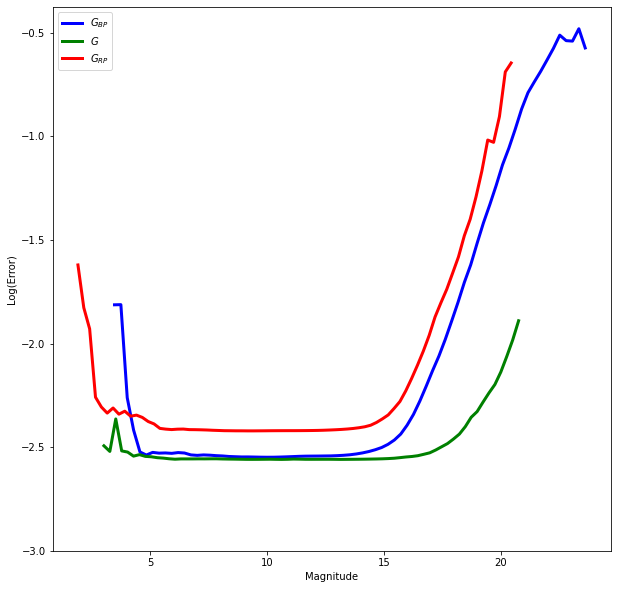

In [12]:
from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = bspline(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = bspline(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = bspline(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(kdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

In [13]:
# np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][star],
#                 kdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][star],
#                 kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][star],
#                 kdr17['J'][star],kdr17['H'][star],kdr17['K'][star]],
#                [bperr[star],gerr[star],rperr[star],kdr17['J_ERR'][star],
#                 kdr17['H_ERR'][star],kdr17['K_ERR'][star]]]).T


In [14]:
# # Initialize Aetas 
# te = np.array([kdr17['TEFF'][0],kdr17['TEFF_ERR'][0]])

# lg = np.array([kdr17['LOGG'][0],kdr17['LOGG_ERR'][0]])

# ab = np.squeeze(np.array([[kdr17['FE_H'][0],apoafe[0]],
#                [kdr17['FE_H_ERR'][0],apoafe_err[0]]]).T)

# op = np.squeeze(np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][0],
#                 kdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][0],
#                 kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][0],
#                 kdr17['J'][0],kdr17['H'][0],kdr17['K'][0]],
#                [bperr[0],gerr[0],rperr[0],kdr17['J_ERR'][0],
#                 kdr17['H_ERR'][0],kdr17['K_ERR'][0]]]).T)

# di = np.array([(1/kdr17['GAIAEDR3_PARALLAX'][0])*1000,(kdr17['GAIAEDR3_PARALLAX_ERROR'][0]/kdr17['GAIAEDR3_PARALLAX'][0]**2)*1000])

# CalcMass = Astrologium(te,lg,ab,op,di,massive)

# exts = CalcMass.extinction()
# CalcMass.bolometric_correction()
# print(exts)
# print(CalcMass.get_mass())
# # print(CalcMass.mass_2_age(kasc_mass[0]))

In [50]:
kasc_ext = 999999.0*np.ones((len(kdr17),6))
kasc_ext_err = 999999.0*np.ones((len(kdr17),6))
kasc_bcs = 999999.0*np.ones((len(kdr17),6))
kasc_bcs_err = 999999.0*np.ones((len(kdr17),6))
kasc_mass = 999999.0*np.ones(len(kdr17))
kasc_mass_err = 999999.0*np.ones(len(kdr17))
# kasc_chi = 999999.0*np.ones(len(kdr17))
# kasc_rmse = 999999.0*np.ones(len(kdr17))
# kasc_age = 999999.0*np.ones(len(kdr17))

for i in tqdm(range(len(kdr17))):
    
    # Initialize Aetas 
    te = np.array([kdr17['TEFF'][i],kdr17['TEFF_ERR'][i]])
    
    lg = np.array([kdr17['LOGG'][i],kdr17['LOGG_ERR'][i]])
    
    ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
                   [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],kdr17['K'][i]],
                   [bperr[i],gerr[i],rperr[i],kdr17['J_ERR'][i],
                    kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
    
    di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcMass = Astrologium(te,lg,ab,op,di,massive)
    
    exts = CalcMass.exts
    kasc_ext[i,:],kasc_ext_err[i,:] = exts[:,0],exts[:,1]
    bcs = CalcMass.bcs
    kasc_bcs[i,:],kasc_bcs_err[i,:] = bcs[:,0],bcs[:,1]
    mss = CalcMass.mass
    kasc_mass[i],kasc_mass_err[i] = mss[0],mss[1]
#     kasc_mass[i],kasc_chi[i],kasc_rmse[i] = CalcMass.get_mass()
#     kasc_age[i] = CalcMass.mass_2_age(kasc_mass[i])

  0%|          | 0/6099 [00:00<?, ?it/s]

<ipython-input-49-ad3ebc96beac>:413: RuntimeWarning: overflow encountered in double_scalars
  mass = 10**lgmass
<ipython-input-49-ad3ebc96beac>:90: RuntimeWarning: invalid value encountered in log10
  self.distmod = 5.0*np.log10(distance)-5.0


In [52]:
kasc_mass

array([inf, inf, inf, ..., inf, inf, inf])

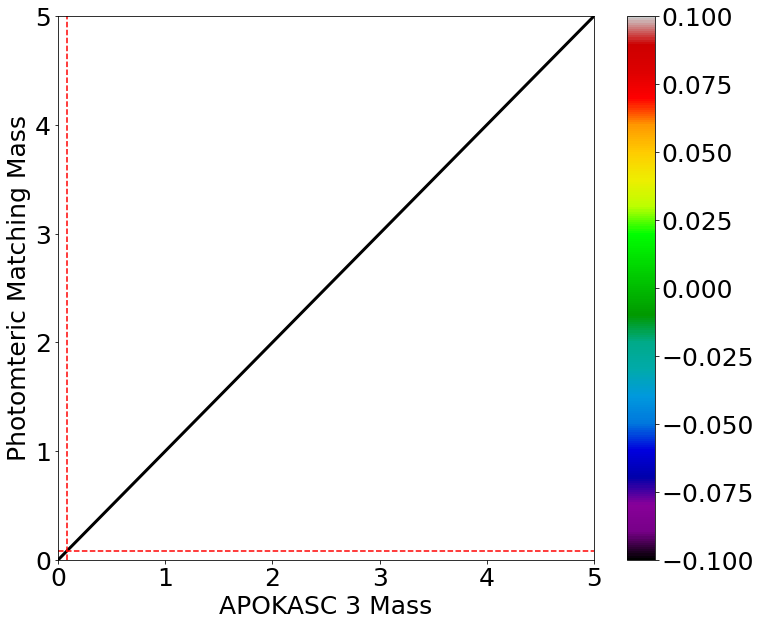

In [51]:
plt.figure(figsize=[12,10])
plt.scatter(k674['APOKASC3P_MASS'],kasc_mass,s=10,c=salfeh,cmap='nipy_spectral')
plt.colorbar()
plt.plot([0,5],[0,5],c='k',lw=3.0)
plt.axvline(0.08,c='r',ls='--')
plt.axhline(0.08,c='r',ls='--')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'Photomteric Matching Mass')
plt.show()

In [31]:
np.nanmax(k674['APOKASC3P_MASS'])

2.570942

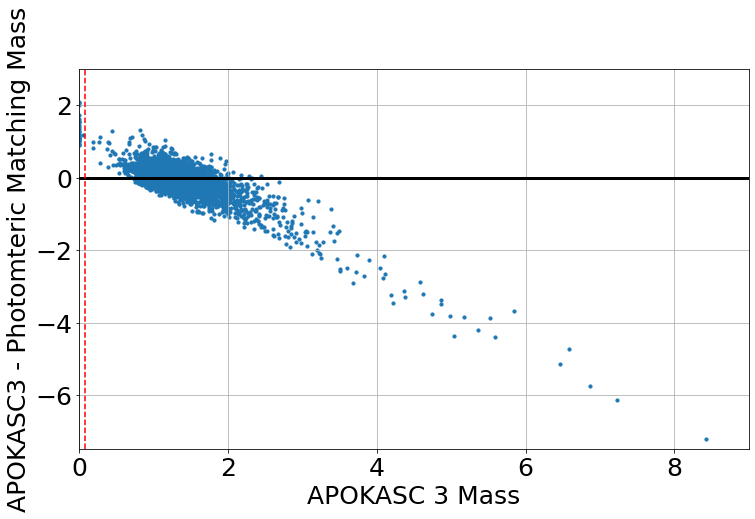

In [32]:
plt.figure(figsize=[12,7])
plt.scatter(kasc_mass,k674['APOKASC3P_MASS']-kasc_mass,s=10)
plt.axhline(0,c='k',lw=3.0)
plt.axvline(0.08,c='r',ls='--')
# plt.plot([0,5],[0,5],c='k',lw=3.0)
plt.grid()
plt.xlim(0,9)
plt.ylim(-7.5,3)
plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'APOKASC3 - Photomteric Matching Mass')
plt.show()

In [33]:
print('Too Big: ',len(np.squeeze(np.where(kasc_mass>10.))))
print('Too Small: ',len(np.squeeze(np.where(kasc_mass<0.08))))

Too Big:  46
Too Small:  39


In [34]:
print(len(np.squeeze(np.where(kasc_mass>2.6))))

149


In [35]:
# import pdb

parsec_age = 999999.0*np.ones(len(kdr17))
match_age = 999999.0*np.ones(len(kdr17))

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mass_2_age_PARSEC(mass,salfeh,teff,isochrones):
    '''
    Inputs:
    ------
        mass: star mass in Msun
        teff: teff
        salfeh: Salaris corrected [Fe/H]
        isochrones: table of PARSEC isochrones
    
    Output:
    ------
        age: age in Gyr
    '''
    
    feh_lo,feh_hi = neighbors(isochrones['MH'],salfeh)
    
    test = np.where((isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
#     pdb.set_trace()
    
    idx_lo = np.where((isochrones['MH']==feh_lo)&
                                 (isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
    iso_lo = isochrones[idx_lo]
    
    idx_hi = np.where((isochrones['MH']==feh_hi)&
                                 (isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
    iso_hi = isochrones[idx_hi]
    
    try:
        # lower [Fe/H]
        sidx_lo = np.argsort(iso_lo['Mass'])
        smass_lo = iso_lo['Mass'][sidx_lo]
        _,uidx_lo = np.unique(smass_lo,return_index=True)
        smass_lo = smass_lo[uidx_lo]
        sage_lo = 10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9

        spl_lo = interp1d(smass_lo,sage_lo)

        # higher [Fe/H]
        sidx_hi = np.argsort(iso_hi['Mass'])
        smass_hi = iso_hi['Mass'][sidx_hi]
        _,uidx_hi = np.unique(smass_hi,return_index=True)
        smass_hi = smass_hi[uidx_hi]
        sage_hi = 10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9

        spl_hi = interp1d(smass_hi,sage_hi)

        # final spline
        final_spl = interp1d([feh_lo,feh_hi],[spl_lo(mass),spl_hi(mass)])
        age = final_spl(salfeh)
        return age
    except:
        return 999999.0

for i in tqdm(range(len(kdr17))):
    parsec_age[i] = mass_2_age_PARSEC(k674['APOKASC3P_MASS'][i],salfeh[i],kdr17['TEFF'][i],massive)
    match_age[i] = mass_2_age_PARSEC(kasc_mass[i],salfeh[i],kdr17['TEFF'][i],massive)

  0%|          | 0/6099 [00:00<?, ?it/s]

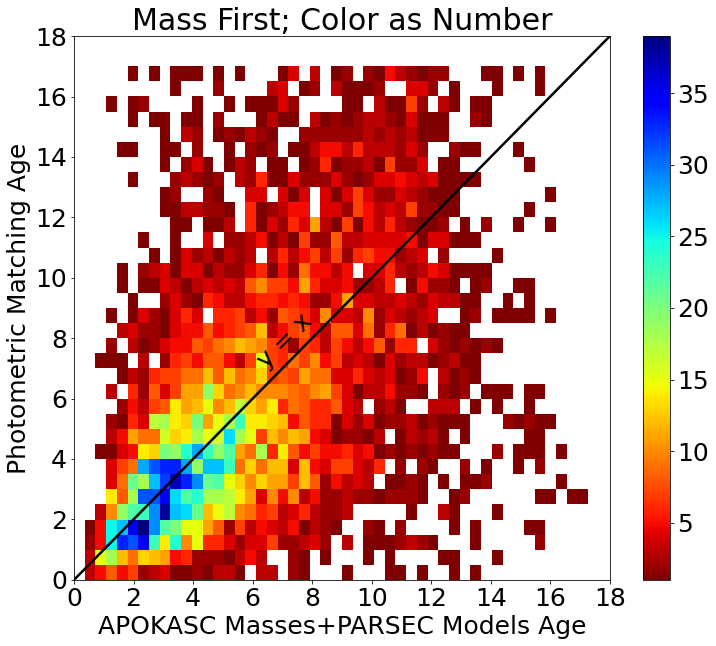

In [24]:
plt.figure(figsize=[12,10])
xmax = 18
ymax = 25
nbins = 50

age2age_fincut = np.where((np.isfinite(match_age)==True)&(match_age<100.)&
                         (np.isfinite(parsec_age)==True)&
                         (parsec_age<100.))

age2age_ret = binned_statistic_2d(parsec_age,match_age,
                                  parsec_age,'count',
                                  bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/nbins)])

age2age_ret.statistic[age2age_ret.statistic == 0.0] = np.nan

im = plt.imshow(age2age_ret.statistic.T, origin='lower',
                extent=[age2age_ret.x_edge[0],age2age_ret.x_edge[-1],
                        age2age_ret.y_edge[0],age2age_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.plot([0,18],[0,18],lw=2.5,c='k')
# plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
# plt.plot([0,17.25],[4,17.25+4],lw=2.5,c='k')
# plt.plot([0,10.95],[11,11],lw=2.5,c='k')

# plt.plot([11,11],[0,5.5],c='k',lw=2.5)
# plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

xshift = 0
yshift = 0
plt.text(6+xshift,7+yshift,'y = x',rotation=45)
# plt.text(8+xshift,4.8+yshift,'y = x - 4',rotation=45)
# plt.text(4+xshift,8.8+yshift,'y = x + 4',rotation=45)
# plt.text(0.75,11.3,'y = 11')


plt.xlim(0,18)
plt.ylim(0,18)

plt.xticks(np.arange(0,19)[::2],np.arange(0,19)[::2].astype('str'))
plt.yticks(np.arange(0,19)[::2],np.arange(0,19)[::2].astype('str'))

plt.title(r'Mass First; Color as Number')
plt.xlabel(r'APOKASC Masses+PARSEC Models Age')
plt.ylabel(r'Photometric Matching Age')

plt.savefig('mass_first_age2age_apokasc.png',bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=[12,10])
xmax = 18
ymax = 25
nbins = 50

age2age_fincut = np.where((np.isfinite(kasc_age)==True)&(kasc_age<100.)&
                         (np.isfinite(parsec_age)==True)&
                         (parsec_age<100.))

age2age_ret = binned_statistic_2d(parsec_age,kasc_age,
                                  parsec_age,'count',
                                  bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/nbins)])

age2age_ret.statistic[age2age_ret.statistic == 0.0] = np.nan

im = plt.imshow(age2age_ret.statistic.T, origin='lower',
                extent=[age2age_ret.x_edge[0],age2age_ret.x_edge[-1],
                        age2age_ret.y_edge[0],age2age_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.plot([0,18],[0,18],lw=2.5,c='k')
# plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
# plt.plot([0,17.25],[4,17.25+4],lw=2.5,c='k')
# plt.plot([0,10.95],[11,11],lw=2.5,c='k')

# plt.plot([11,11],[0,5.5],c='k',lw=2.5)
# plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

xshift = 0
yshift = 0
plt.text(6+xshift,7+yshift,'y = x',rotation=45)
# plt.text(8+xshift,4.8+yshift,'y = x - 4',rotation=45)
# plt.text(4+xshift,8.8+yshift,'y = x + 4',rotation=45)
# plt.text(0.75,11.3,'y = 11')


plt.xlim(0,18)
plt.ylim(0,18)

plt.xticks(np.arange(0,19)[::2],np.arange(0,19)[::2].astype('str'))
plt.yticks(np.arange(0,19)[::2],np.arange(0,19)[::2].astype('str'))

plt.title(r'Mass First; Color as Number')
plt.xlabel(r'APOKASC Masses+PARSEC Models Age')
plt.ylabel(r'Photometric Matching Age')

plt.show()

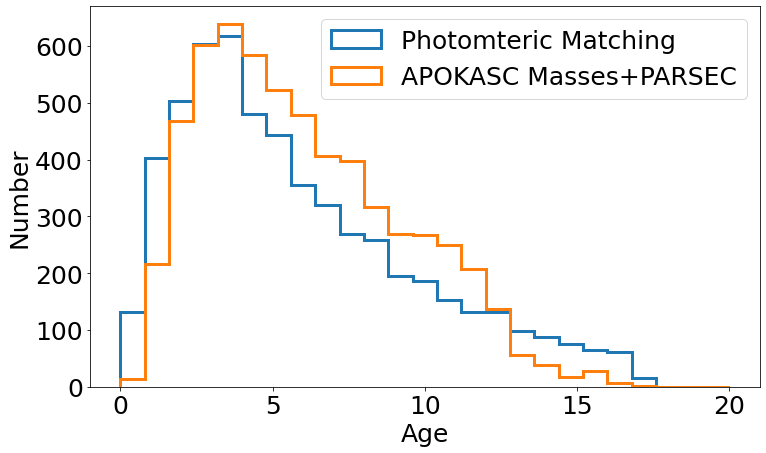

In [25]:
plt.figure(figsize=[12,7])
plt.hist(match_age,range=(0,20),bins=25,histtype='step',lw=3.0,label='Photomteric Matching')
plt.hist(parsec_age,range=(0,20),bins=25,histtype='step',lw=3.0,label='APOKASC Masses+PARSEC')
plt.legend()
plt.xlabel(r'Age')
plt.ylabel(r'Number')
plt.savefig('mass_first_agehist_apokasc.png',bbox_inches='tight')
plt.show()

(array([5586.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  513.]),
 array([6.45110759e-02, 4.00000219e+04, 7.99999794e+04, 1.19999937e+05,
        1.59999894e+05, 1.99999852e+05, 2.39999809e+05, 2.79999766e+05,
        3.19999724e+05, 3.59999681e+05, 3.99999639e+05, 4.39999596e+05,
        4.79999554e+05, 5.19999511e+05, 5.59999468e+05, 5.99999426e+05,
        6.39999383e+05, 6.79999341e+05, 7.19999298e+05, 7.59999255e+05,
        7.99999213e+05, 8.39999170e+05, 8.79999128e+05, 9.19999085e+05,
        9.59999043e+05, 9.99999000e+05]),
 [<matplotlib.patches.Polygon at 0x7fb78bc0a700>])

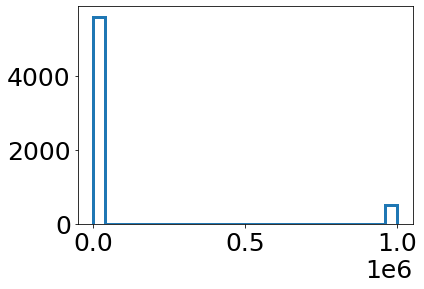

In [26]:
plt.hist(match_age,bins=25,histtype='step',lw=3.0,label='Photomteric Matching')